In [4]:
# Load necessary packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials , space_eval
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

# About the dataset

In [5]:
#Read data
#data = pd.read_csv('../input/titanic/train.csv')

data = pd.read_csv ('Titanic_train.csv')

#Printing first 5 rows
data[:5]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


# Is the data imbalanced?

In [7]:
data['Survived'].value_counts()


Survived
0    549
1    342
Name: count, dtype: int64

<Axes: xlabel='Survived', ylabel='count'>

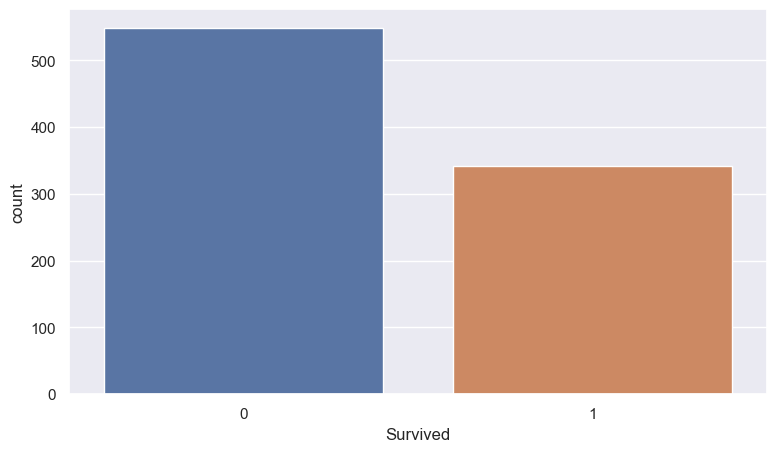

In [8]:
sns.set()
sns.set(rc = {'figure.figsize':(9,5)})
sns.countplot(x="Survived",data=data)

# Missing values?

In [22]:

#Checking for Nan values in features excluding PassengerId, Name
print('Nan values exist in')
for col in [data.columns[i] for i in range(0, len(data.columns))]: #[1,2,4,5,6,7,8,9,10,11]]:
    print(col,':', any(data[col].isna()))

Nan values exist in
PassengerId : False
Survived : False
Pclass : False
Name : False
Sex : False
Age : True
SibSp : False
Parch : False
Ticket : False
Fare : False
Cabin : True
Embarked : True


# Age

In [23]:
data['Age'] = data['Age'].fillna('nan')

print(data[data['Age'] == 'nan']['Age'])

5      nan
17     nan
19     nan
26     nan
28     nan
      ... 
859    nan
863    nan
868    nan
878    nan
888    nan
Name: Age, Length: 177, dtype: object


In [24]:
def impute_missing_data(test, col, median, mode):
    if col in test :
        test[col] = test[col].fillna('nan')

        test_feature = test.drop(test[test[col]== 'nan'].index, axis= 0)[col]

        nan_index = test[test[col]== 'nan'].index

        for i in nan_index:
            if median == True:
                test[col].iloc[i] = test_feature.median()
            elif mode == True:
                test[col].iloc[i] = test_feature.value_counts().index[0]
        
    return test

In [25]:
#Imputing mean values for missing data
data = impute_missing_data(data, 'Age', median =True, mode=False)

In [ ]:
any(data['Age'].isna())

In [29]:
data['Age'] = data['Age'].map(lambda x: int(x))

In [ ]:
'''data = data.drop(data[data['Age']== 'nan'].index, axis= 0)
data.info()'''

# Cabin

In [27]:
data['Cabin'] = data['Cabin'].fillna('nan')

print(data[data['Cabin'] == 'nan']['Cabin'])

0      nan
2      nan
4      nan
5      nan
7      nan
      ... 
884    nan
885    nan
886    nan
888    nan
890    nan
Name: Cabin, Length: 687, dtype: object


In [36]:
#Imputing the mode values for missing data
data = impute_missing_data(data, 'Embarked', median = False, mode = True)

In [37]:
any(data['Embarked'].isna())

False

In [38]:
data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,nan,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,nan,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,nan,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27,0,0,211536,13.0000,nan,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,28,1,2,W./C. 6607,23.4500,nan,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26,0,0,111369,30.0000,C148,C


In [ ]:
plt.bar(dict(data.corrwith(data["Survived"])).keys(), dict(data.corrwith(data["Survived"])).values())

# EDA

# Age of the people who survived?

Three visualizations :

1. Boxplots : To tell us about the distribution of the feature for each output class and give us an idea about the outliers in the data

2. Density plots : To tell us about the distribution and more about the shape of the distribution (resembling normal or any other disb) of the feature

3. Stacked countplots : Tells us more about count of each category of the feature with information about the percentage belonging to which output class


Text(0.5, 1.0, 'Density plot')

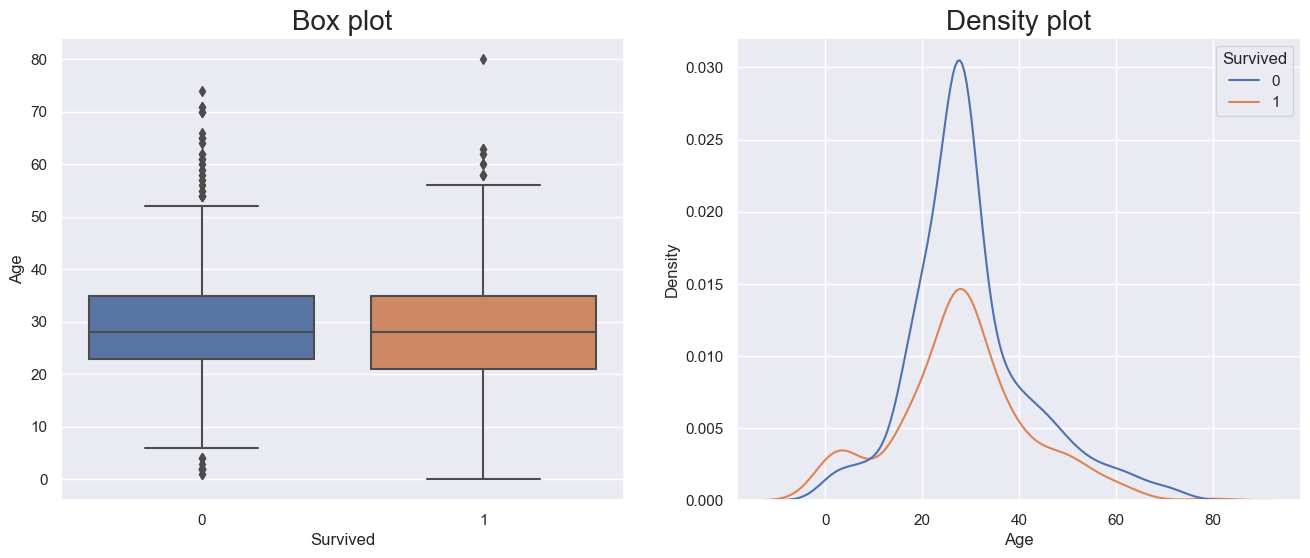

In [34]:
sns.set(rc = {'figure.figsize':(16,6)})
plt.plot(figure_size = (1,2))

#Boxplots
plt.subplot(1,2,1)
bp_ax = sns.boxplot(x = "Survived",y="Age", data = data)
bp_ax.set_title('Box plot', fontsize = 20)

#Density plots
plt.subplot(1,2,2)
dp_ax = sns.kdeplot(x = 'Age', hue = 'Survived', data = data)
dp_ax.set_title('Density plot', fontsize = 20)

In [42]:
def calculate_stacked_plot_percentages(df_plot, df_p):
    #Find the counts for each age bin for calcualting percentage
    df_plot_sum = df_plot.sum(axis=1)
    class_sum = np.array([df_plot_sum.iloc[int(i/2)] if i%2==0 else df_plot_sum.iloc[int((i-1)/2)] for i in range(2*len(df_plot_sum)) ]).reshape((len(df_plot_sum),2)).T.flatten()
    class_list = zip(np.roll(df_plot.to_numpy().T.flatten(), len(df_plot)), class_sum, list(df_p.axes.patches))

    return class_list

Survived        0    1
age_bin               
(-0.1, 27.0]  189  130
(27.0, 53.0]  326  196
(53.0, 80.0]   34   16


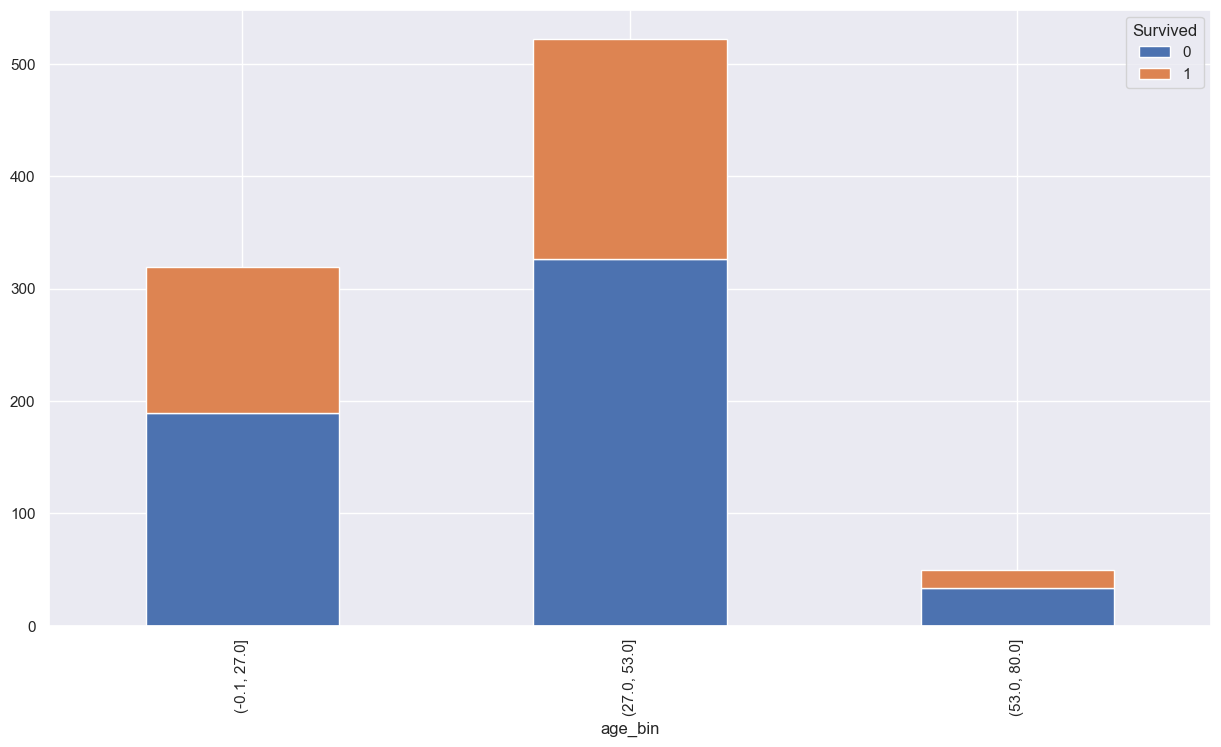

In [46]:
#Stacked countplot : https://stackoverflow.com/questions/50319614/count-plot-with-stacked-bars-per-hue #Add percentages on stacked countplots : https://stackoverflow.com/questions/31749448/how-to-add-percentages-on-top-of-bars-in-seaborn
sns.set(rc = {'figure.figsize':(15,8)})

#Find the bins
data['age_bin'] = pd.cut(data['Age'], 3, precision = 0)

#Calculate the counts of categorical variable Survived for different age bins
df_plot = data.groupby([ 'Survived', 'age_bin']).size().reset_index().pivot(columns='Survived', index='age_bin', values=0)
print(df_plot)

#Plot the stacked bar plot
df_p = df_plot.plot(kind='bar', stacked=True)


In [47]:
#how to drop outliers from data after analysing with boxplot : https://datascience.stackexchange.com/questions/54808/how-to-remove-outliers-using-box-plot
def drop_outliers(data , col):
    Q1 = data['Age'].quantile(0.25)
    Q3 = data['Age'].quantile(0.75)
    IQR = Q3 - Q1    #IQR is interquartile range. 

    filter = (data['Age'] >= Q1 - 1.5 * IQR) & (data['Age'] <= Q3 + 1.5 *IQR) #filter filters out data within Q1 - 1.5*IQR to Q3 + 1.5*IQR
    data = data.loc[filter]
    return data

In [48]:
#data = drop_outliers(data , 'Age')
#data

# Sex of the surviors ?

Survived    0    1
Sex               
female     81  233
male      468  109


Text(0.5, 0, 'Sex')

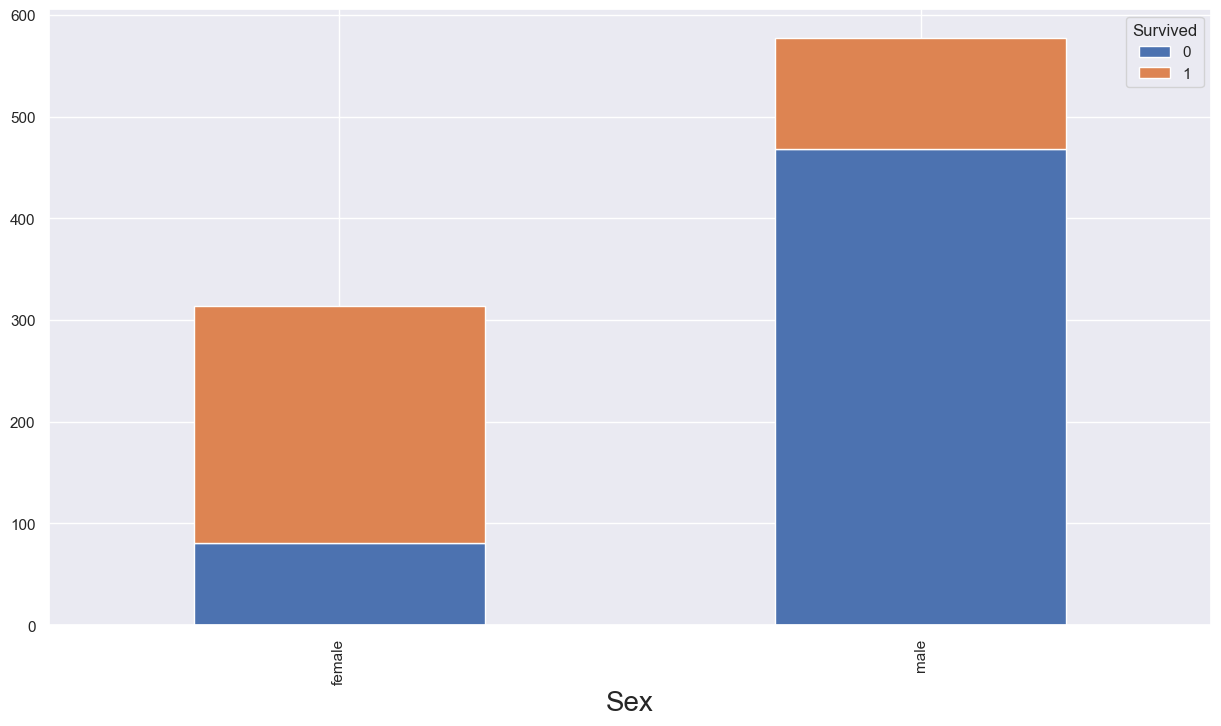

In [53]:
#Stacked countplot : https://stackoverflow.com/questions/50319614/count-plot-with-stacked-bars-per-hue #Add percentages on stacked countplots : https://stackoverflow.com/questions/31749448/how-to-add-percentages-on-top-of-bars-in-seaborn
sns.set(rc = {'figure.figsize':(15,8)})

#Calculate the counts of categorical variable Survived for different age bins
df_plot = data.groupby([ 'Survived', 'Sex']).size().reset_index().pivot(columns='Survived', index='Sex', values=0)
print(df_plot)

#Plot the stacked bar plot
df_p = df_plot.plot(kind='bar', stacked=True)

#Set labels
df_p.set_xlabel("Sex", fontsize = 20)


In [ ]:
#data = drop_outliers(data , 'Sex')
#data

# Fares of the survivors?

Text(0.5, 1.0, 'Density plot')

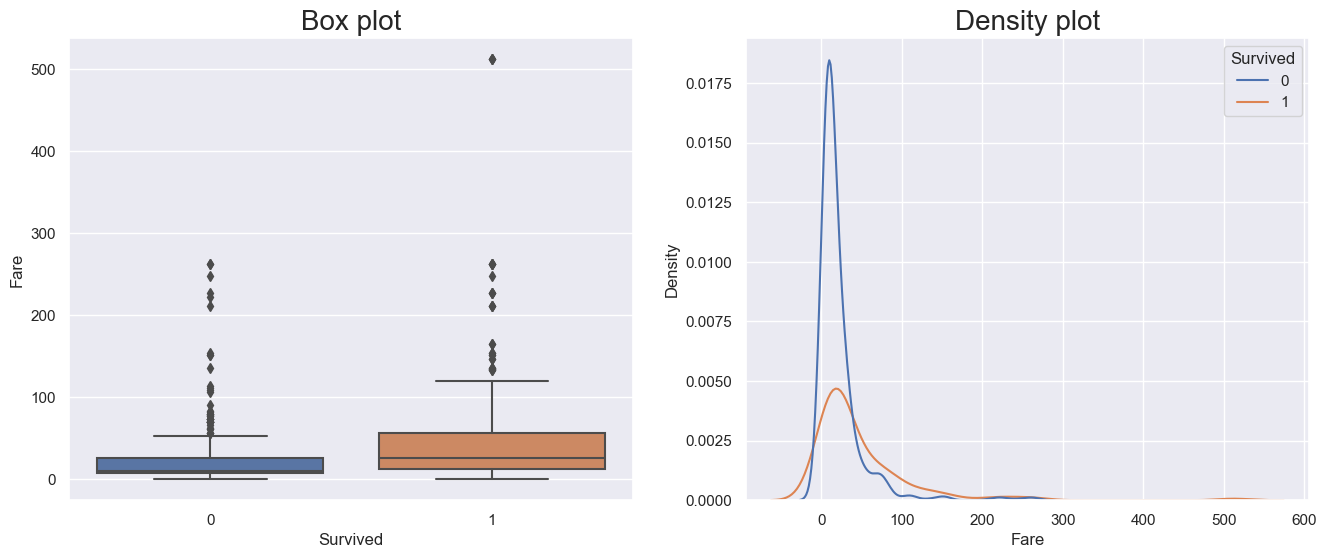

In [54]:
sns.set(rc = {'figure.figsize':(16,6)})
plt.plot(figure_size = (1,2))

#Boxplots
plt.subplot(1,2,1)
bp_ax = sns.boxplot(x = "Survived",y="Fare", data = data)
bp_ax.set_title('Box plot', fontsize = 20)

#Density plots
plt.subplot(1,2,2)
dp_ax = sns.kdeplot(x = 'Fare', hue = 'Survived', data = data)
dp_ax.set_title('Density plot', fontsize = 20)

In [ ]:
#data = drop_outliers(data , 'Fare')
#data

# Converting fares into categorical variables

In [55]:
def fares_categorical(data):
    data['fare_bin'] = pd.cut(data['Fare'], 3, precision = 0)
    return data

data = fares_categorical(data)
map_obj = {(-1.0, 171.0) : 0, (171.0, 342.0): 1,(342.0, 512.0):2}
data['fare_bin'] = data['fare_bin'].map(lambda x: map_obj[(x.left, x.right)])

Text(0.5, 1.0, 'Box plot')

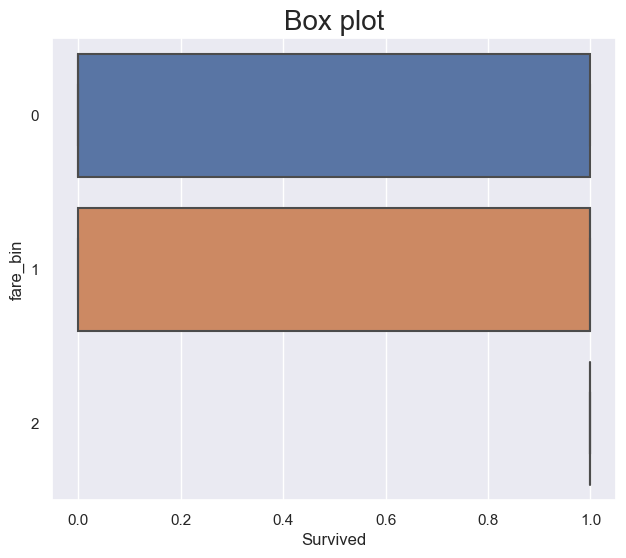

In [56]:
sns.set(rc = {'figure.figsize':(16,6)})
plt.plot(figure_size = (1,2))

#Boxplots
plt.subplot(1,2,1)
bp_ax = sns.boxplot(x = "Survived",y="fare_bin", data = data)
bp_ax.set_title('Box plot', fontsize = 20)

#Density plots
#plt.subplot(1,2,2)
#dp_ax = sns.kdeplot(x = 'fare_bin', hue = 'Survived', data = data)
#dp_ax.set_title('Density plot', fontsize = 20)

# Port embarked of survivors?

Survived    0    1
Embarked          
C          75   93
Q          47   30
S         427  219


Text(0.5, 0, 'Embarked')

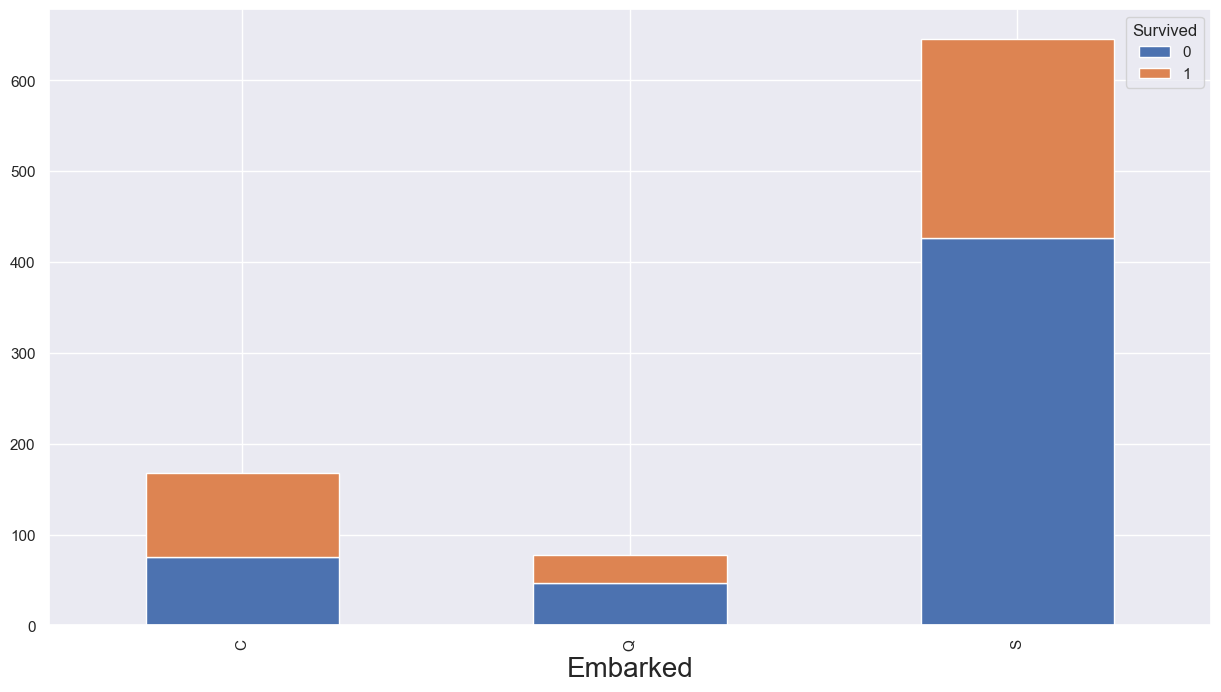

In [58]:
sns.set(rc = {'figure.figsize':(15,8)})

#Calculate the counts of categorical variable Survived for different age bins
df_plot = data.groupby([ 'Survived', 'Embarked']).size().reset_index().pivot(columns='Survived', index='Embarked', values=0)
print(df_plot)

#Plot the stacked bar plot
df_p = df_plot.plot(kind='bar', stacked=True)

#Set labels
df_p.set_xlabel("Embarked", fontsize = 20)


# Name of the survivors

Name Title

In [59]:
data['Name'].value_counts()

Name
Braund, Mr. Owen Harris                     1
Boulos, Mr. Hanna                           1
Frolicher-Stehli, Mr. Maxmillian            1
Gilinski, Mr. Eliezer                       1
Murdlin, Mr. Joseph                         1
                                           ..
Kelly, Miss. Anna Katherine "Annie Kate"    1
McCoy, Mr. Bernard                          1
Johnson, Mr. William Cahoone Jr             1
Keane, Miss. Nora A                         1
Dooley, Mr. Patrick                         1
Name: count, Length: 891, dtype: int64

In [60]:
data_name_title_1 = data[data['Name'].str.contains('Miss')]['Name']
data_name_title_2 = data[data['Name'].str.contains('Mrs')]['Name']
data_name_title_3 = data[data['Name'].str.contains('Master')]['Name']
data_name_title_4 = data[data['Name'].str.contains('Mr')]['Name']
data_name_title_5 = data[~ (data['Name'].str.contains('Miss') | data['Name'].str.contains('Mrs') | data['Name'].str.contains('Mr') | data['Name'].str.contains('Master'))]['Name']

In [61]:
data_name_title_5.value_counts()

Name
Uruchurtu, Don. Manuel E                                    1
Byles, Rev. Thomas Roussel Davids                           1
Harper, Rev. John                                           1
Reuchlin, Jonkheer. John George                             1
Leader, Dr. Alice (Farnham)                                 1
Brewe, Dr. Arthur Jackson                                   1
Rothes, the Countess. of (Lucy Noel Martha Dyer-Edwards)    1
Crosby, Capt. Edward Gifford                                1
Weir, Col. John                                             1
Frauenthal, Dr. Henry William                               1
Simonius-Blumer, Col. Oberst Alfons                         1
Sagesser, Mlle. Emma                                        1
Stahelin-Maeglin, Dr. Max                                   1
Kirkland, Rev. Charles Leonard                              1
Butt, Major. Archibald Willingham                           1
Peuchen, Major. Arthur Godfrey                              1
Rey

In [62]:
def name_encoding(data):
    data['name_title'] = [np.nan for i in range(len(data))]

    data_name_title_1 = data[data['Name'].str.contains('Miss')]['Name']
    data_name_title_2 = data[data['Name'].str.contains('Mrs')]['Name']
    data_name_title_3 = data[data['Name'].str.contains('Master')]['Name']
    data_name_title_4 = data[data['Name'].str.contains('Mr')]['Name']
    data_name_title_5 = data[~ (data['Name'].str.contains('Miss') | data['Name'].str.contains('Mrs') | data['Name'].str.contains('Mr') | data['Name'].str.contains('Master'))]['Name']
    
    for i in range(len(data)):
        if data['Name'].iloc[i] in list(data_name_title_1):
            data['name_title'].iloc[i] = 0
        elif data['Name'].iloc[i] in list(data_name_title_2):
            data['name_title'].iloc[i] = 1
        elif data['Name'].iloc[i] in list(data_name_title_3):
            data['name_title'].iloc[i] = 2
        elif data['Name'].iloc[i] in list(data_name_title_4):
            data['name_title'].iloc[i] = 3
        elif data['Name'].iloc[i] in list(data_name_title_5):
            data['name_title'].iloc[i] = 4
        
    return data

In [ ]:
data = name_encoding(data)

# Name title (without m/f)

In [66]:
data_name_title_1 = data[data['Name'].str.contains('Miss') | data['Name'].str.contains('Mrs') | data['Name'].str.contains('Mr') | data['Name'].str.contains('Master')]['Name']
data_name_title_2 = data[~ (data['Name'].str.contains('Miss') | data['Name'].str.contains('Mrs') | data['Name'].str.contains('Mr') | data['Name'].str.contains('Master'))]['Name']

In [67]:
data_name_title_2.value_counts()

Name
Uruchurtu, Don. Manuel E                                    1
Byles, Rev. Thomas Roussel Davids                           1
Harper, Rev. John                                           1
Reuchlin, Jonkheer. John George                             1
Leader, Dr. Alice (Farnham)                                 1
Brewe, Dr. Arthur Jackson                                   1
Rothes, the Countess. of (Lucy Noel Martha Dyer-Edwards)    1
Crosby, Capt. Edward Gifford                                1
Weir, Col. John                                             1
Frauenthal, Dr. Henry William                               1
Simonius-Blumer, Col. Oberst Alfons                         1
Sagesser, Mlle. Emma                                        1
Stahelin-Maeglin, Dr. Max                                   1
Kirkland, Rev. Charles Leonard                              1
Butt, Major. Archibald Willingham                           1
Peuchen, Major. Arthur Godfrey                              1
Rey

In [68]:
def name_encoding_1(data):
    data['name_title_1'] = [np.nan for i in range(len(data))]
    data_name_title_1 = data[data['Name'].str.contains('Miss') | data['Name'].str.contains('Mrs') | data['Name'].str.contains('Mr') | data['Name'].str.contains('Master')]['Name']
    data_name_title_2 = data[~ (data['Name'].str.contains('Miss') | data['Name'].str.contains('Mrs') | data['Name'].str.contains('Mr') | data['Name'].str.contains('Master'))]['Name']    
    for i in range(len(data)):
        if data['Name'].iloc[i] in list(data_name_title_1):
            data['name_title_1'].iloc[i] = 0
        elif data['Name'].iloc[i] in list(data_name_title_2):
            data['name_title_1'].iloc[i] = 1
        
    return data

# Letter of surname

In [71]:
data['Name'].value_counts()

Name
Braund, Mr. Owen Harris                     1
Boulos, Mr. Hanna                           1
Frolicher-Stehli, Mr. Maxmillian            1
Gilinski, Mr. Eliezer                       1
Murdlin, Mr. Joseph                         1
                                           ..
Kelly, Miss. Anna Katherine "Annie Kate"    1
McCoy, Mr. Bernard                          1
Johnson, Mr. William Cahoone Jr             1
Keane, Miss. Nora A                         1
Dooley, Mr. Patrick                         1
Name: count, Length: 891, dtype: int64

In [72]:
highest = {}
for letter in ["A","B","C","D","E","F","G","H","I","J","K","L","M","N","O","P","Q","R","S","T","U","V","W","X","Y","Z"]:
    data_name_1 = data['Name'][data['Name'].str.startswith(letter)]
    highest[letter] = len(data_name_1)

In [73]:
highest = sorted(highest.items(), key = lambda x:x[1], reverse = True)
print('Maximum occurence of letters in surname beginning :',highest[:5])

Maximum occurence of letters in surname beginning : [('S', 86), ('M', 74), ('B', 72), ('C', 69), ('H', 69)]


In [74]:
def surname_encoding(data):
    data['surname'] = [np.nan for i in range(len(data))]
    
    data_surname_1 = data['Name'][data['Name'].str.startswith("S")]
    data_surname_2 = data['Name'][data['Name'].str.startswith("M")]
    data_surname_3 = data['Name'][data['Name'].str.startswith("B")]
    data_surname_4 = data['Name'][data['Name'].str.startswith("C")]
    data_surname_5 = data['Name'][data['Name'].str.startswith("H")]
    data_surname_6 = data['Name'][~ (data['Name'].str.startswith("S") | data['Name'].str.startswith("M") | data['Name'].str.startswith("B")| data['Name'].str.startswith("C")| data['Name'].str.startswith("H"))]
    
    for i in range(len(data)):
        if data['Name'].iloc[i] in list(data_surname_1):
            data['surname'].iloc[i] = 0
        elif data['Name'].iloc[i] in list(data_surname_2):
            data['surname'].iloc[i] = 1
        elif data['Name'].iloc[i] in list(data_surname_3):
            data['surname'].iloc[i] = 2
        elif data['Name'].iloc[i] in list(data_surname_4):
            data['surname'].iloc[i] = 3
        elif data['Name'].iloc[i] in list(data_surname_5):
            data['surname'].iloc[i] = 4
        elif data['Name'].iloc[i] in list(data_surname_6):
            data['surname'].iloc[i] = 5

        
    return data

In [75]:
data = surname_encoding(data)

Text(0.5, 1.0, 'Density plot')

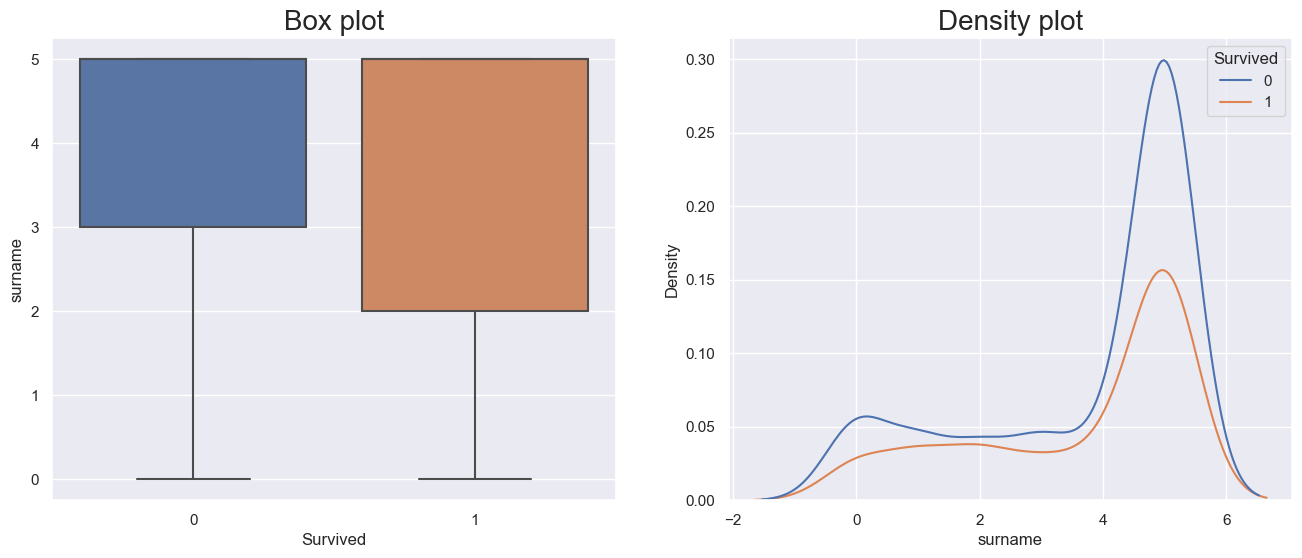

In [76]:
sns.set(rc = {'figure.figsize':(16,6)})
plt.plot(figure_size = (1,2))

#Boxplots
plt.subplot(1,2,1)
bp_ax = sns.boxplot(x = "Survived",y="surname", data = data)
bp_ax.set_title('Box plot', fontsize = 20)

#Density plots
plt.subplot(1,2,2)
dp_ax = sns.kdeplot(x = 'surname', hue = 'Survived', data = data)
dp_ax.set_title('Density plot', fontsize = 20)

# Tickets of survivors?

In [77]:
data_ticket_1 = data[data['Ticket'].str.isdigit() == True]['Ticket']
print(data_ticket_1)

3      113803
4      373450
5      330877
6       17463
7      349909
        ...  
885    382652
886    211536
887    112053
889    111369
890    370376
Name: Ticket, Length: 661, dtype: object


In [78]:
data_ticket_2 = data[data['Ticket'].str.isdigit() == False]['Ticket']
print(data_ticket_2.value_counts())

Ticket
CA. 2343              7
CA 2144               6
S.O.C. 14879          5
PC 17757              4
LINE                  4
                     ..
F.C.C. 13528          1
SOTON/O.Q. 3101311    1
A/5 3540              1
PC 17610              1
SOTON/OQ 392076       1
Name: count, Length: 167, dtype: int64


In [79]:
data_ticket_2_1 = data_ticket_2[data_ticket_2.str.startswith("C")]
print(data_ticket_2_1, len(data_ticket_2_1))

33           C.A. 24579
56           C.A. 31026
58           C.A. 34651
59              CA 2144
66           C.A. 29395
70           C.A. 33111
71              CA 2144
93            C.A. 2315
127             C 17369
134          C.A. 29178
145          C.A. 33112
159            CA. 2343
161          C.A. 33595
180            CA. 2343
201            CA. 2343
234          C.A. 29566
237          C.A. 31921
265          C.A. 17248
279           C.A. 2673
324            CA. 2343
348          C.A. 37671
365              C 7076
376              C 7077
386             CA 2144
439          C.A. 18723
450          C.A. 34651
472          C.A. 34651
480             CA 2144
489          C.A. 37671
497           C.A. 6212
508              C 4001
516          C.A. 34260
549          C.A. 33112
637          C.A. 31921
649            CA. 2314
672          C.A. 24580
678             CA 2144
683             CA 2144
746           C.A. 2673
788           C.A. 2315
792            CA. 2343
801          C.A

In [80]:
data_ticket_2_2 = data_ticket_2[data_ticket_2.str.startswith("S")]
print(data_ticket_2_2, len(data_ticket_2_2))

2      STON/O2. 3101282
43        SC/Paris 2123
45      S.C./A.4. 23567
67            S.P. 3464
72         S.O.C. 14879
             ...       
827     S.C./PARIS 2079
840    SOTON/O2 3101287
841         S.O./P.P. 3
866       SC/PARIS 2149
884     SOTON/OQ 392076
Name: Ticket, Length: 65, dtype: object 65


In [81]:
data_ticket_2_3 = data_ticket_2[data_ticket_2.str.startswith("P")]
print(data_ticket_2_3, len(data_ticket_2_3))

1       PC 17599
10       PP 9549
30      PC 17601
31      PC 17569
34      PC 17604
         ...    
793     PC 17600
835     PC 17756
853     PC 17592
867     PC 17590
874    P/PP 3381
Name: Ticket, Length: 65, dtype: object 65


In [82]:
data_ticket_2_4 = data_ticket_2[~ (data_ticket_2.str.startswith("C") | data_ticket_2.str.startswith("S") | data_ticket_2.str.startswith("P"))]
print(data_ticket_2_4, len(data_ticket_2_4))

0         A/5 21171
12        A/5. 2151
37       A./5. 2152
51       A/4. 39886
86       W./C. 6608
92      W.E.P. 5734
121       A4. 54510
132       A/5. 3337
147      W./C. 6608
152      A.5. 11206
153        A/5. 851
154       Fa 265302
179            LINE
204        A/5 3540
211    F.C.C. 13528
212       A/5 21174
219       W/C 14208
227       A/5 21173
235      W./C. 6609
242     W./C. 14263
253       A/5. 3336
271            LINE
283      A/5. 10482
302            LINE
304        A/5 2466
314    F.C.C. 13529
320       A/5 21172
421      A/5. 13032
425      A/4. 34244
436      W./C. 6608
440    F.C.C. 13529
454        A/5 2817
458    F.C.C. 13531
464        A/S 2816
482        A/5 3594
488      A.5. 18509
494       A/4 45380
526     W./C. 14258
535    F.C.C. 13529
540       WE/P 5735
565       A/4 48871
574      A/4. 20589
589      A./5. 3235
592        A/5 3902
597            LINE
617       A/5. 3336
668        A/5 3536
671      F.C. 12750
736      W./C. 6608
745       WE/P 5735


In [83]:
def ticket_bin_encoding(data):
    data['ticket_bin'] = [np.nan for i in range(len(data))]
    
    data_ticket_1 = data[data['Ticket'].str.isdigit() == True]['Ticket']
    data_ticket_2 = data[data['Ticket'].str.isdigit() == False]['Ticket']
    #data_ticket_2_1 = data_ticket_2[data_ticket_2.str.startswith("C")]
    #data_ticket_2_2 = data_ticket_2[data_ticket_2.str.startswith("P")]
    #data_ticket_2_3 = data_ticket_2[data_ticket_2.str.startswith("S")]
    #data_ticket_2_4 = data_ticket_2[~ (data_ticket_2.str.startswith("C") | data_ticket_2.str.startswith("S") | data_ticket_2.str.startswith("P"))]
    
    for i in range(len(data)):
        if data['Ticket'].iloc[i] in list(data_ticket_1):
            data['ticket_bin'].iloc[i] = 0
        elif data['Ticket'].iloc[i] in list(data_ticket_2):
            data['ticket_bin'].iloc[i] = 1
        #elif data['Ticket'].iloc[i] in list(data_ticket_2_1):
        #    data['ticket_bin'].iloc[i] = 1
        #elif data['Ticket'].iloc[i] in list(data_ticket_2_2):
        #    data['ticket_bin'].iloc[i] = 2
        #elif data['Ticket'].iloc[i] in list(data_ticket_2_3):
        #    data['ticket_bin'].iloc[i] = 3
        #elif data['Ticket'].iloc[i] in list(data_ticket_2_4):
        #    data['ticket_bin'].iloc[i] = 4
        
        
    return data

In [84]:
data = ticket_bin_encoding(data)

In [85]:
data['ticket_bin'].value_counts()


ticket_bin
0.0    661
1.0    230
Name: count, dtype: int64

Survived      0    1
ticket_bin          
0.0         407  254
1.0         142   88


Text(0.5, 0, 'ticket_bin')

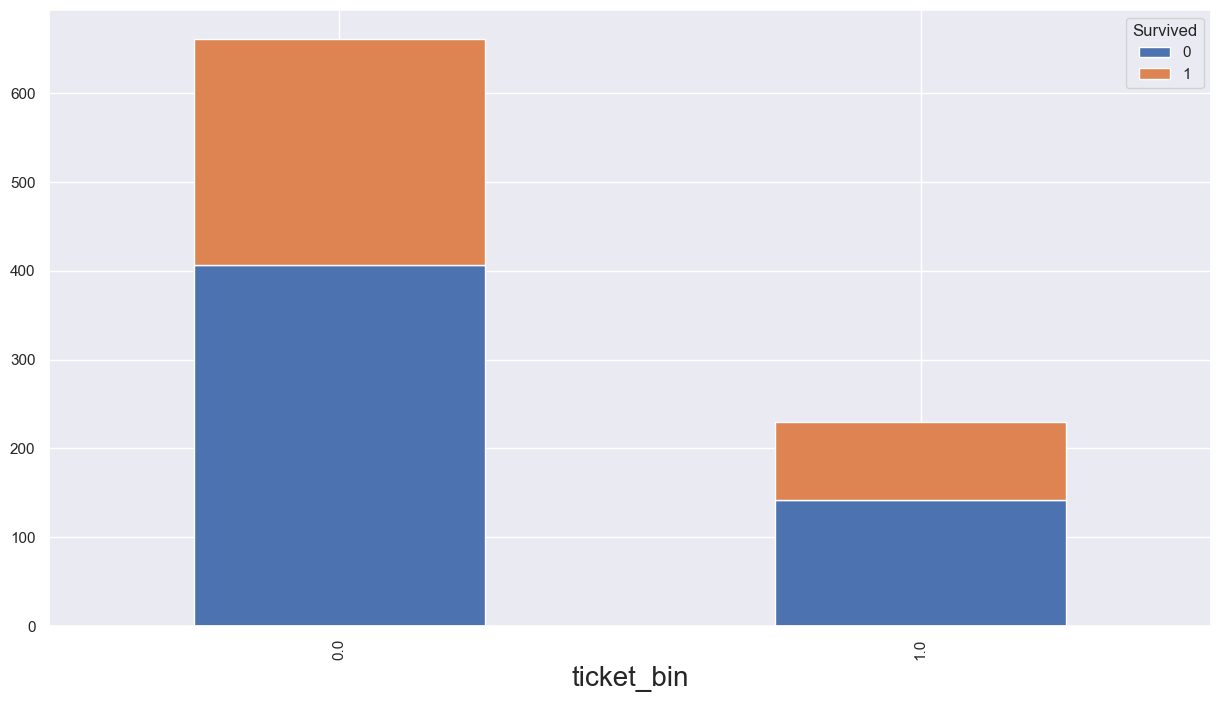

In [87]:
sns.set(rc = {'figure.figsize':(15,8)})

#Calculate the counts of categorical variable Survived for different age bins
df_plot = data.groupby([ 'Survived', 'ticket_bin']).size().reset_index().pivot(columns='Survived', index='ticket_bin', values=0)
print(df_plot)

#Plot the stacked bar plot
df_p = df_plot.plot(kind='bar', stacked=True)

#Set labels
df_p.set_xlabel("ticket_bin", fontsize = 20)


# Cabin of the survivors

In [88]:
data['Cabin'].value_counts()


Cabin
nan            687
C23 C25 C27      4
G6               4
B96 B98          4
C22 C26          3
              ... 
E34              1
C7               1
C54              1
E36              1
C148             1
Name: count, Length: 148, dtype: int64

In [89]:
def cabin_encoding(data):
    data['cabin_bin'] = [np.nan for i in range(len(data))]
    
    data_cabin_1 = data['Cabin'][data['Cabin'].str.startswith("A")]
    data_cabin_2 = data['Cabin'][data['Cabin'].str.startswith("B")]
    data_cabin_3 = data['Cabin'][data['Cabin'].str.startswith("C")]
    data_cabin_4 = data['Cabin'][data['Cabin'].str.startswith("D")]
    data_cabin_5 = data['Cabin'][data['Cabin'].str.startswith("E")]
    data_cabin_6 = data['Cabin'][~ (data['Cabin'].str.startswith("A") | data['Cabin'].str.startswith("B") | data['Cabin'].str.startswith("C")| data['Cabin'].str.startswith("D")| data['Cabin'].str.startswith("E"))]
    
    for i in range(len(data)):
        if data['Cabin'].iloc[i] in list(data_cabin_1):
            data['cabin_bin'].iloc[i] = 0
        elif data['Cabin'].iloc[i] in list(data_cabin_2):
            data['cabin_bin'].iloc[i] = 1
        elif data['Cabin'].iloc[i] in list(data_cabin_3):
            data['cabin_bin'].iloc[i] = 2
        elif data['Cabin'].iloc[i] in list(data_cabin_4):
            data['cabin_bin'].iloc[i] = 3
        elif data['Cabin'].iloc[i] in list(data_cabin_5):
            data['cabin_bin'].iloc[i] = 4
        elif data['Cabin'].iloc[i] in list(data_cabin_6):
            data['cabin_bin'].iloc[i] = 5
        elif data['Cabin'].iloc[i] == 'nan':
            data['cabin_bin'].iloc[i] = 6

    return data

In [90]:
data = cabin_encoding(data)

Text(0.5, 1.0, 'Density plot')

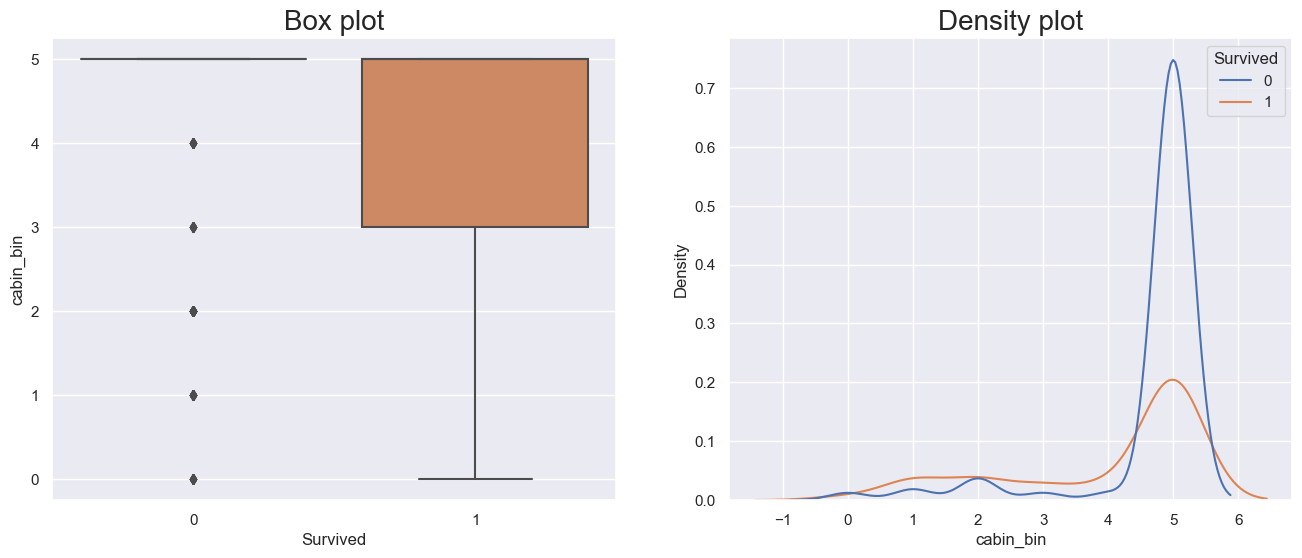

In [91]:
sns.set(rc = {'figure.figsize':(16,6)})
plt.plot(figure_size = (1,2))

#Boxplots
plt.subplot(1,2,1)
bp_ax = sns.boxplot(x = "Survived",y="cabin_bin", data = data)
bp_ax.set_title('Box plot', fontsize = 20)

#Density plots
plt.subplot(1,2,2)
dp_ax = sns.kdeplot(x = 'cabin_bin', hue = 'Survived', data = data)
dp_ax.set_title('Density plot', fontsize = 20)

# Number of family members of the survivors ? (SibSp, Parch)

Text(0.5, 1.0, 'Density plot')

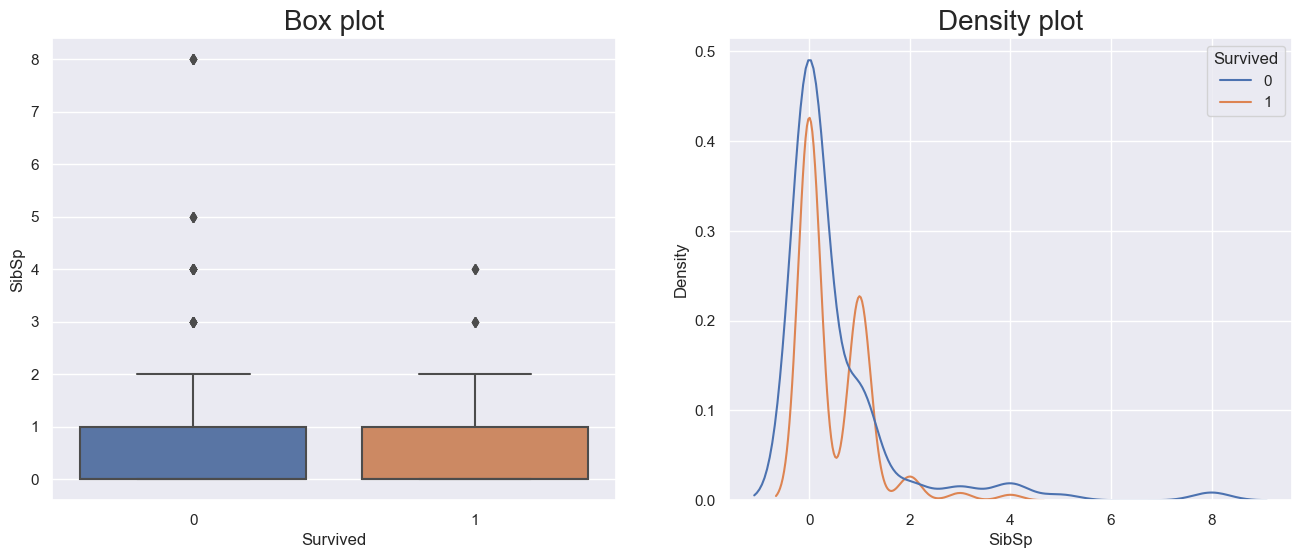

In [92]:
sns.set(rc = {'figure.figsize':(16,6)})
plt.plot(figure_size = (1,2))

#Boxplots
plt.subplot(1,2,1)
bp_ax = sns.boxplot(x = "Survived",y="SibSp", data = data)
bp_ax.set_title('Box plot', fontsize = 20)

#Density plots
plt.subplot(1,2,2)
dp_ax = sns.kdeplot(x = 'SibSp', hue = 'Survived', data = data)
dp_ax.set_title('Density plot', fontsize = 20)

Text(0.5, 1.0, 'Density plot')

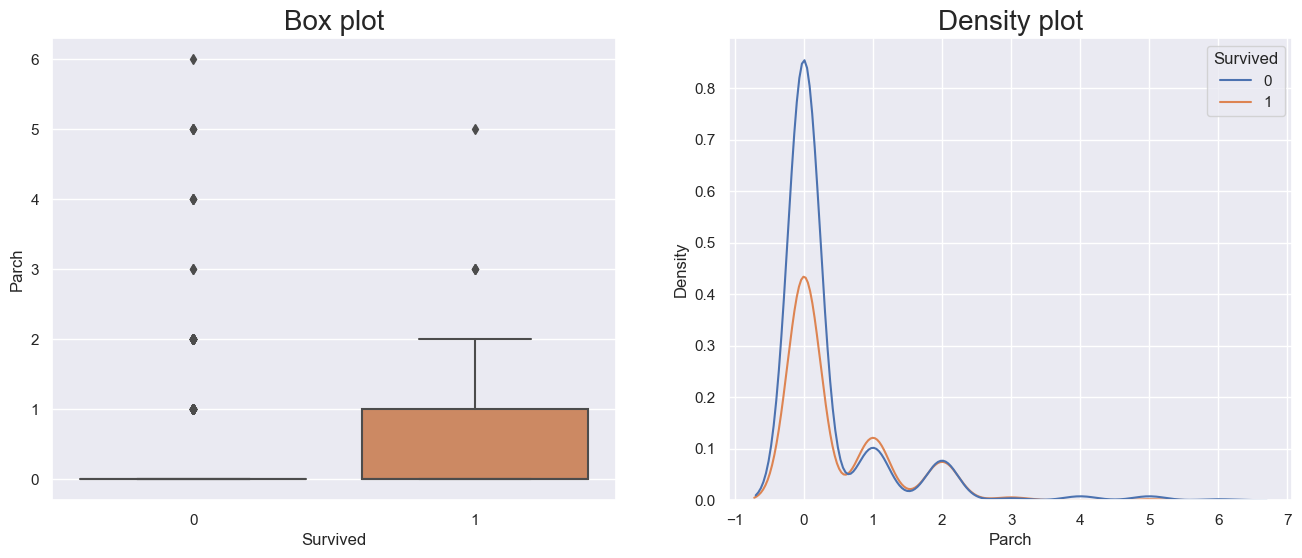

In [93]:
sns.set(rc = {'figure.figsize':(16,6)})
plt.plot(figure_size = (1,2))

#Boxplots
plt.subplot(1,2,1)
bp_ax = sns.boxplot(x = "Survived",y="Parch", data = data)
bp_ax.set_title('Box plot', fontsize = 20)

#Density plots
plt.subplot(1,2,2)
dp_ax = sns.kdeplot(x = 'Parch', hue = 'Survived', data = data)
dp_ax.set_title('Density plot', fontsize = 20)

In [94]:
data['family'] = data['SibSp'] + data['Parch']

Text(0.5, 1.0, 'Density plot')

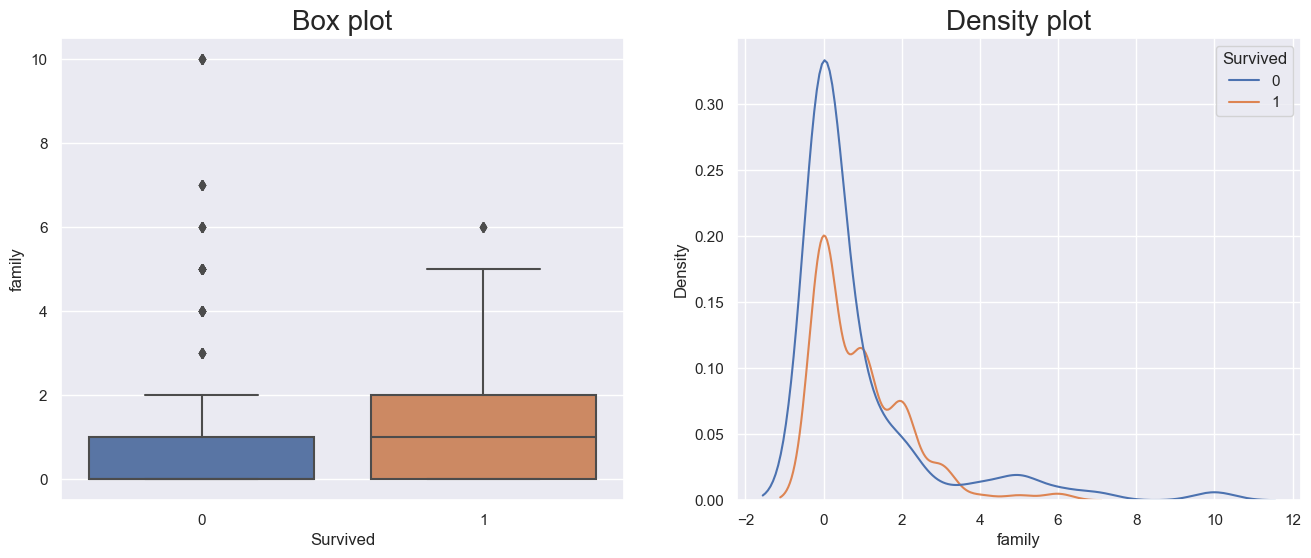

In [95]:
sns.set(rc = {'figure.figsize':(16,6)})
plt.plot(figure_size = (1,2))

#Boxplots
plt.subplot(1,2,1)
bp_ax = sns.boxplot(x = "Survived",y="family", data = data)
bp_ax.set_title('Box plot', fontsize = 20)

#Density plots
plt.subplot(1,2,2)
dp_ax = sns.kdeplot(x = 'family', hue = 'Survived', data = data)
dp_ax.set_title('Density plot', fontsize = 20)

# Ticket class of the surivors ? (Pclass)

1. Around 500 passengers belonged to Class 3 which is the majority of the passengers and 75 % of them did not survive
2. Class 1 and Class 2 had around half of the total Class 1 count but higher percentage of survivors
3. Clearly, percentage of Class 1 and Class 2 survivors is higher (63 % and 47 %) than the percentage of Class 3 survivors (24 %)

Survived    0    1
Pclass            
1          80  136
2          97   87
3         372  119


Text(0.5, 0, 'Pclass')

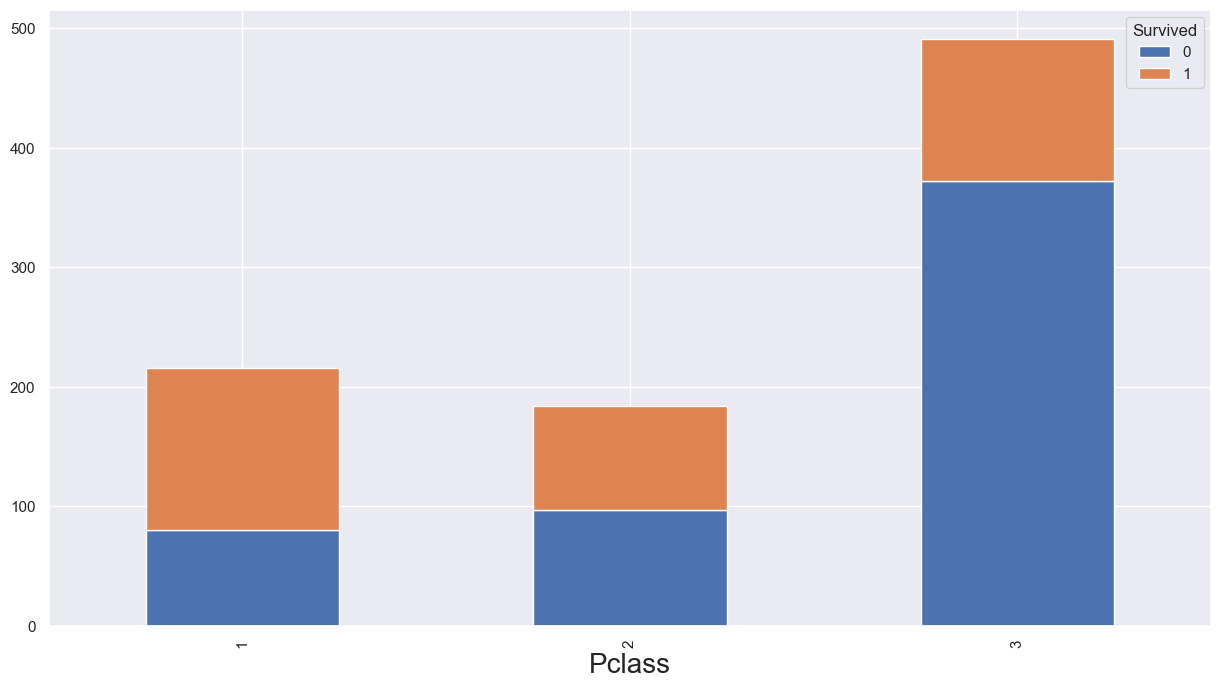

In [98]:
sns.set(rc = {'figure.figsize':(15,8)})

#Calculate the counts of categorical variable Survived for different age bins
df_plot = data.groupby([ 'Survived', 'Pclass']).size().reset_index().pivot(columns='Survived', index='Pclass', values=0)
print(df_plot)

#Plot the stacked bar plot
df_p = df_plot.plot(kind='bar', stacked=True)

#Set labels
df_p.set_xlabel("Pclass", fontsize = 20)


# Correlation w target variable

In [110]:
X = data
categorical_features_ = ['Sex', 'pClass', 'Embarked' ]
numerical_features_ = ['Age', 'SibSp', 'Parch', 'Fare']

for col in categorical_features_:
    if col in X.columns:
        le = LabelEncoder()
        X[col]= le.fit_transform(X[col])    

for col in numerical_features_:
    if col in X.columns:
        le = MinMaxScaler()
        X[col]= le.fit_transform(np.array(X[col]).reshape(-1,1))

In [112]:
sns.set(rc = {'figure.figsize':(14,14)})

# Visualizing

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

data_1000 = X_train
labels_1000 = y_train

model = TSNE(n_components = 2, random_state = 0)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations
# for the optimization = 1000

tsne_data = model.fit_transform(data_1000)

# creating a new data frame which
# help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_1000)).T
tsne_df = pd.DataFrame(data = tsne_data,columns =("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue ="label", size = 6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()

plt.show()

# Hyperparameter optimization using hyperopt

In [ ]:
criterion_list = ["gini", "entropy"]

def hyperopt_train_test(params):
    clf = RandomForestClassifier(**params)
    return cross_val_score(clf, X_train, y_train).mean()

space = {
    'max_depth': hp.choice('max_depth', range(1,20)),
    'max_features': hp.choice('max_features', range(1,5)),
    'n_estimators': hp.choice('n_estimators', range(1,1000)),
    'criterion': hp.choice('criterion', criterion_list)
            }
best = 0
def f(params):
    global best
    acc = hyperopt_train_test(params)
    if acc > best:
      best = acc
      print( 'new best:', best, params)
    return {'loss': -acc, 'status': STATUS_OK}
trials = Trials()
best = fmin(f, space, algo=tpe.suggest, max_evals=10, trials=trials)
print(best)

In [131]:
best

0

In [ ]:
#rf = RandomForestClassifier(criterion = 'gini', max_depth= 10, n_estimators= 500)
rf = RandomForestClassifier(criterion = criterion_list[best['criterion']], max_depth= best['max_depth'], n_estimators= best['n_estimators'])
rf.fit(X_train, y_train)
print('Final accuracy score :',  accuracy_score(rf.predict(X_test), y_test))

# Model 1: Logistic Regression, GLM

In [133]:
from sklearn.linear_model import LogisticRegression

In [132]:
'''penalty_list = ['l1', 'l2', 'elasticnet', 'none']

def hyperopt_train_test(params):
    clf = LogisticRegression(**params)
    return cross_val_score(clf, X_train, y_train).mean()

space = {
    'penalty': hp.choice('penalty', penalty_list),
    'C': hp.choice('C', range(0,100))
            }
best = 0
def f(params):
    global best
    acc = hyperopt_train_test(params)
    if acc > best:
      best = acc
      print( 'new best:', best, params)
    return {'loss': -acc ,'status': STATUS_OK}
trials = Trials()
best = fmin(f, space, algo=tpe.suggest, max_evals=300, trials=trials)
print(best)'''

"penalty_list = ['l1', 'l2', 'elasticnet', 'none']\n\ndef hyperopt_train_test(params):\n    clf = LogisticRegression(**params)\n    return cross_val_score(clf, X_train, y_train).mean()\n\nspace = {\n    'penalty': hp.choice('penalty', penalty_list),\n    'C': hp.choice('C', range(0,100))\n            }\nbest = 0\ndef f(params):\n    global best\n    acc = hyperopt_train_test(params)\n    if acc > best:\n      best = acc\n      print( 'new best:', best, params)\n    return {'loss': -acc ,'status': STATUS_OK}\ntrials = Trials()\nbest = fmin(f, space, algo=tpe.suggest, max_evals=300, trials=trials)\nprint(best)"

In [134]:
'''best'''

'best'

In [ ]:
'''lr = LogisticRegression(C = best['C'], penalty = penalty_list[best['penalty']])
lr.fit(X_train, y_train)
print('Final accuracy score :',  accuracy_score(lr.predict(X_test), y_test))'''

# Model 2 : Generative Additive Models

In [136]:
!pip install pygam
from pygam import LogisticGAM

  Obtaining dependency information for pygam from https://files.pythonhosted.org/packages/ea/a7/d7037173f7c39fd114ca7bc9757149bdfbe2951b5c2cba08038c24e55e10/pygam-0.9.1-py3-none-any.whl.metadata
  Obtaining dependency information for numpy>=1.25 from https://files.pythonhosted.org/packages/3f/6b/5610004206cf7f8e7ad91c5a85a8c71b2f2f8051a0c0c4d5916b76d6cbb2/numpy-1.26.4-cp311-cp311-win_amd64.whl.metadata
     ---------------------------------------- 0.0/61.0 kB ? eta -:--:--
     ---------------------------------------- 0.0/61.0 kB ? eta -:--:--
     ---------------------------------------- 0.0/61.0 kB ? eta -:--:--
     ------ --------------------------------- 10.2/61.0 kB ? eta -:--:--
     ------------------- ------------------ 30.7/61.0 kB 262.6 kB/s eta 0:00:01
     ------------------------- ------------ 41.0/61.0 kB 245.8 kB/s eta 0:00:01
     -------------------------------------- 61.0/61.0 kB 323.6 kB/s eta 0:00:00
  Obtaining dependency information for progressbar2<5.0.0,>=4.2.0

ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\SAI\\anaconda3\\Lib\\site-packages\\~umpy\\core\\_multiarray_tests.cp311-win_amd64.pyd'
Consider using the `--user` option or check the permissions.



ModuleNotFoundError: No module named 'pygam'

In [ ]:
gam = LogisticGAM().fit(X_train, y_train)
gam.summary()

In [ ]:
gam.accuracy(X_test, y_test)

In [ ]:
fig, axs = plt.subplots(1, len(X_train.columns))
titles = X_train.columns

for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, width=.95)

    ax.plot(XX[:, i], pdep)
    ax.plot(XX[:, i], confi, c='r', ls='--')
    ax.set_title(titles[i]);

# Model 3: Ensembles

In [ ]:
import lightgbm as lgb
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

In [ ]:
criterion_list = ["gini", "entropy"]

def hyperopt_train_test(params):
    clf = XGBClassifier(**params)
    return cross_val_score(clf, X_train, y_train).mean()

space = {
    'learning_rate' : hp.choice('learning_rate', [0.001,0.005, 0.01, 0.05, 0.1, 0.2, 0.5, 0.6,1]),
    'max_depth': hp.choice('max_depth', range(1,20)),
    'max_features': hp.choice('max_features', range(1,5)),
    'n_estimators': hp.choice('n_estimators', range(1,1000)),
    'subsample' : hp.choice('subsample', [0,0.5,1])
            }
best = 0
def f(params):
    global best
    acc = hyperopt_train_test(params)
    if acc > best:
      best = acc
      print( 'new best:', best, params)
    return {'loss': -acc, 'status': STATUS_OK}
trials = Trials()
best = fmin(f, space, algo=tpe.suggest, max_evals=10, trials=trials)
print(best)

In [ ]:
Best 

In [ ]:
if best['subsample'] >=1:
    best['subsample'] = 1
xgb = XGBClassifier(subsample = best['subsample'], learning_rate = best['learning_rate'], max_depth= best['max_depth'], n_estimators= best['n_estimators'], objective= 'binary:logistic')
xgb.fit(X_train, y_train)
print('Final accuracy score :',  accuracy_score(xgb.predict(X_test), y_test)

# Voting Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor, RandomForestRegressor, VotingClassifier, VotingRegressor

In [ ]:
''vc = VotingClassifier([("xgb_m",xgb),
                       ("log",lr),
                       ("rf_m",rf)],
                      voting = "hard")''


In [ ]:
'''print('Final accuracy score :'''

# Test predictions

In [ ]:
test = pd.read_csv('../input/titanic/test.csv')
test

In [ ]:
print(test.columns)

In [146]:
#categorical_features = ['Sex', 'pClass', 'Embarked' ]
#numerical_features = ['Age', 'SibSp', 'Parch', 'Fare', 'family', 'name_length']

def clean_data(test):
    for col in [test.columns[i] for i in [1,3,4,5,6,7,8,10]]:
        if any(test[col].isna()) == True and col in ['Age', 'Fare']:
            test = impute_missing_data(test, col, median =True, mode=False)

                
    return test


def preprocess(test):
    test['Cabin'] = test['Cabin'].fillna('nan')
    test['cabin_nan'] = [1 if test['Cabin'].iloc[i] =='nan' else 0 for i in range(len(test))]

    test = ticket_bin_encoding(test)
    test = name_encoding(test)
    test['family'] = test['SibSp'] + test['Parch']
    test['name_length'] = test['Name'].map(lambda x: len(str(x)))
    #test = name_vectorizer(test)
    test = cabin_encoding(test)
    test = name_encoding_1(test)
    test = surname_encoding(test)
    test = fares_categorical(test)
    map_obj = {(-1.0, 171.0) : 0, (171.0, 342.0): 1,(342.0, 512.0):2}
    test['fare_bin'] = test['fare_bin'].map(lambda x: map_obj[(x.left, x.right)])
    test = combine_categorical_vars(test, 'Pclass','fare_bin')
    test = combine_categorical_vars(test, 'Pclass_fare_bin', 'cabin_bin')
    test = combine_categorical_vars(test, 'Sex','name_title')
    test = name_length_categorical(test)
    map_obj = {(test['name_length_bin'].value_counts().keys()[0].left, test['name_length_bin'].value_counts().keys()[0].right) : 0, (test['name_length_bin'].value_counts().keys()[1].left, test['name_length_bin'].value_counts().keys()[1].right): 1,(test['name_length_bin'].value_counts().keys()[2].left, test['name_length_bin'].value_counts().keys()[2].right):2}
    test['name_length_bin'] = test['name_length_bin'].map(lambda x: map_obj[(x.left, x.right)])

    drop_list = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'ticket_bin', 'cabin_nan', 'Fare']
    drop_list = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp', 'Parch','name_title','name_title_1', 'fare_bin', 'Pclass_fare_bin','name_length']
    
    test = pd.get_dummies(test, columns = cols_dummies)

    test = test.drop(columns = drop_list)##Incl cabin
    
    for col in categorical_features:
        if col in test.columns:
            try:
                le = LabelEncoder()
                test[col]= le.fit_transform(test[col])
            except:
                pass
        
    for col in numerical_features:
        le = MinMaxScaler()
        if col in test.columns:
            test[col]= le.fit_transform(np.array(test[col]).reshape(-1,1))
        
                
    return test

In [ ]:
test = clean_data(test)

for col in [test.columns[i] for i in [1,3,4,5,6,7,8,10]]:
    print(col,':', any(test[col].isna()))
    
test = preprocess(test)

In [ ]:
test

In [ ]:
submission = pd.read_csv('../input/titanic/gender_submission.csv')
submission

In [ ]:
pred = gam.predict(test)
gam_pred = [1 if i == True else 0 for i in pred ]

'''rf_pred = rf.predict(test)

lr_pred = lr.predict(test)

xgb_pred =xgb.predict(test)

vc_pred = vc.predict(test)'''

In [ ]:
'''final_pred = [1 if (i + 2*j+k)/4 >=0.5 else 0 for i,j,k in zip(gam_pred, rf_pred, lr_pred)]'''

In [ ]:
submission['Survived'] = rf.predict(test)#final_pred#vc_pred#final_pred #gam_pred #rf.predict(test) 

In [ ]:
submission

In [ ]:
submission.to_csv('./submission.csv', index = False)

# Correlation between features and target variable

In [ ]:
sns.heatmap(test.corr(),
            #vmin=-1, vmax=1, center=0,
            cmap=sns.diverging_palette(50, 500, n=500),
            square=True)

In [ ]:
plt.bar(dict(test.corrwith(submission["Survived"])).keys(), dict(test.corrwith(submission["Survived"])).values())

# Results: